In [9]:
from google.colab import files
import pandas as pd
import numpy as np

uploaded = files.upload()
df = pd.read_csv(list(uploaded.keys())[0])
print(df.shape)
df.head()


Saving Loan_Default.csv to Loan_Default (1).csv
(148670, 34)


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [10]:
TARGET = "Status"
for col in ["ID"]:
    if col in df.columns:
        df = df.drop(columns=[col])
df = df.replace([np.inf, -np.inf], np.nan)
df[TARGET] = df[TARGET].astype(int)

print(df[TARGET].value_counts())


Status
0    112031
1     36639
Name: count, dtype: int64


In [11]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((118936, 32), (29734, 32))

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

numeric_process = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_process = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_process, num_cols),
    ('cat', categorical_process, cat_cols)
])

In [28]:
!pip install -q xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=4, min_samples_leaf=30, min_samples_split=60,criterion="gini", random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=150, max_depth=5,
        min_samples_leaf=20, min_samples_split=40,
        class_weight="balanced", random_state=42
    ),
    "Naive Bayes": GaussianNB(),
    "Linear SVM": LinearSVC(class_weight='balanced', max_iter=5000, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        max_depth=2,
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=0.6,
        min_child_weight=15,
        gamma=4.0,
        reg_alpha=2.0,
        reg_lambda=10.0,
        eval_metric='auc',
        random_state=42,
        n_jobs=-1,
    )
}


In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(model, name, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"\n🔹 {name} Accuracy: {acc*100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return {"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}


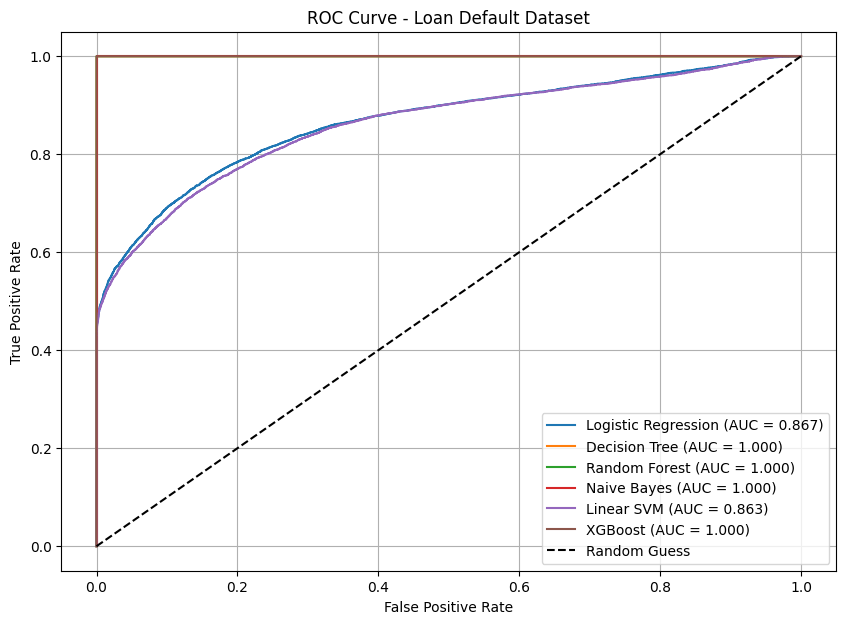

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

for name, clf in models.items():

    # Pipeline for each model
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('clf', clf)
    ])

    pipe.fit(X_train, y_train)

    # Get values for ROC curve
    fpr, tpr, roc_auc = get_roc_auc(pipe, X_test, y_test)

    # Plot
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")


plt.plot([0,1], [0,1], 'k--', label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Loan Default Dataset")
plt.legend()
plt.grid(True)
plt.show()


In [31]:
from sklearn.metrics import roc_curve, auc

def get_roc_auc(pipe, X_test, y_test):
    try:
        y_prob = pipe.predict_proba(X_test)[:, 1]   # for models with predict_proba
    except:
        y_prob = pipe.decision_function(X_test)     # for SVM (no prob)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc



==================== Training Logistic Regression ====================

🔹 Logistic Regression Accuracy: 83.88%
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     22406
           1       0.66      0.71      0.68      7328

    accuracy                           0.84     29734
   macro avg       0.78      0.80      0.79     29734
weighted avg       0.84      0.84      0.84     29734



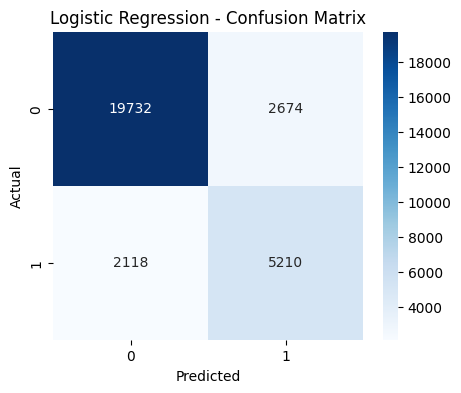


==================== Training Decision Tree ====================

🔹 Decision Tree Accuracy: 99.97%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



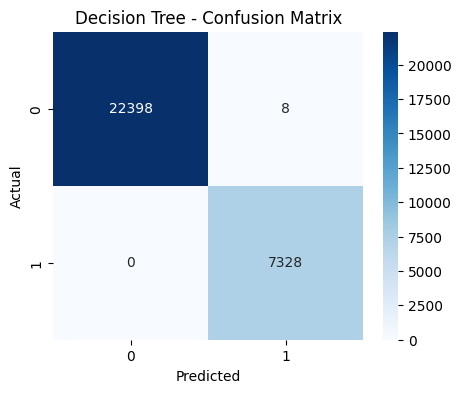


==================== Training Random Forest ====================

🔹 Random Forest Accuracy: 99.98%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



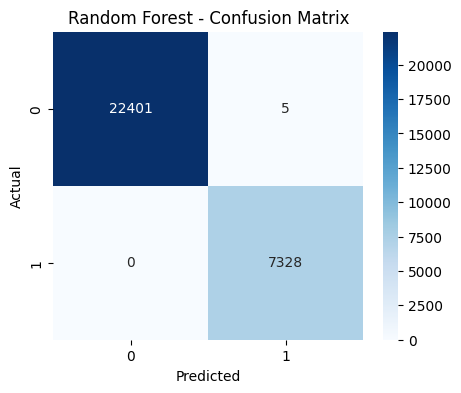


==================== Training Naive Bayes ====================

🔹 Naive Bayes Accuracy: 87.31%
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     22406
           1       1.00      0.48      0.65      7328

    accuracy                           0.87     29734
   macro avg       0.93      0.74      0.79     29734
weighted avg       0.89      0.87      0.86     29734



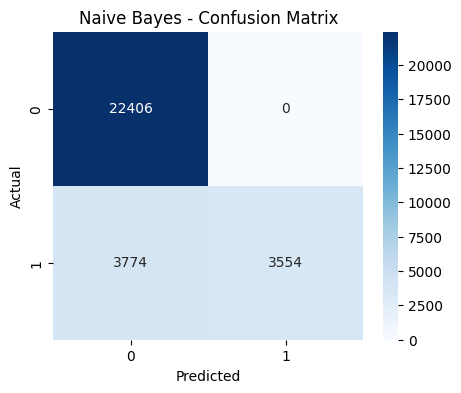


==================== Training Linear SVM ====================

🔹 Linear SVM Accuracy: 83.82%
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     22406
           1       0.67      0.69      0.68      7328

    accuracy                           0.84     29734
   macro avg       0.78      0.79      0.78     29734
weighted avg       0.84      0.84      0.84     29734



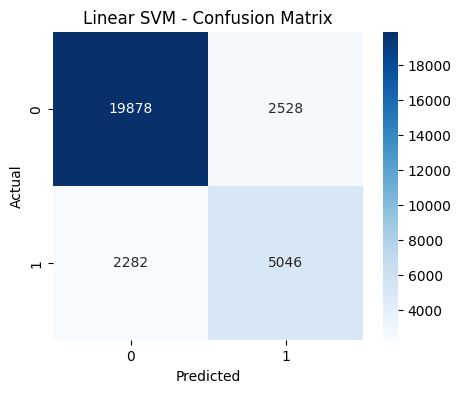


==================== Training XGBoost ====================

🔹 XGBoost Accuracy: 99.98%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



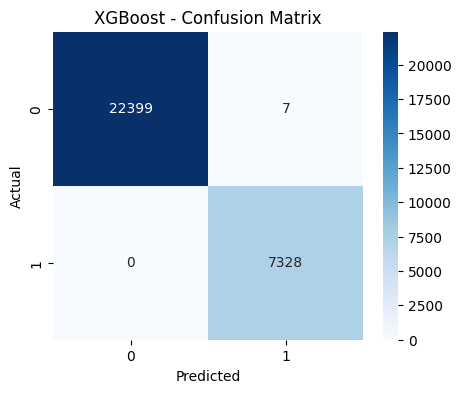

,Model,Accuracy,Precision,Recall,F1,Accuracy %
0,Logistic Regression,0.838838,0.660832,0.710972,0.684986,83.88
1,Decision Tree,0.999731,0.998909,1.000000,0.999454,99.97
2,Random Forest,0.999832,0.999318,1.000000,0.999659,99.98
3,Naive Bayes,0.873075,1.000000,0.484989,0.653189,87.31
4,Linear SVM,0.838232,0.666227,0.688592,0.677225,83.82
5,XGBoost,0.999765,0.999046,1.000000,0.999523,99.98


In [32]:
results_loan = []

for name, clf in models.items():
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('clf', clf)
    ])
    print(f"\n==================== Training {name} ====================")
    pipe.fit(X_train, y_train)
    res = evaluate_model(pipe, name, X_test, y_test)
    results_loan.append(res)

results_loan_df = pd.DataFrame(results_loan)
results_loan_df["Accuracy %"] = (results_loan_df["Accuracy"] * 100).round(2)
results_loan_df


In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0)
    }


In [34]:
combined_results = []

for name, clf in models.items():

    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('clf', clf)
    ])

    print(f"\nTraining {name}...")
    pipe.fit(X_train, y_train)

    # TRAIN predictions
    y_train_pred = pipe.predict(X_train)
    train_m = calculate_metrics(y_train, y_train_pred)

    # TEST predictions
    y_test_pred = pipe.predict(X_test)
    test_m = calculate_metrics(y_test, y_test_pred)

    combined_results.append({
        "Model": name,
        "Train Accuracy": train_m["Accuracy"],
        "Test Accuracy": test_m["Accuracy"],

        "Train Precision": train_m["Precision"],
        "Test Precision": test_m["Precision"],

        "Train Recall": train_m["Recall"],
        "Test Recall": test_m["Recall"],

        "Train F1": train_m["F1"],
        "Test F1": test_m["F1"],
    })



Training Logistic Regression...

Training Decision Tree...

Training Random Forest...

Training Naive Bayes...

Training Linear SVM...

Training XGBoost...


In [35]:
combined_results_df = pd.DataFrame(combined_results)


combined_results_df["Train Accuracy %"] = (combined_results_df["Train Accuracy"]*100).round(2)
combined_results_df["Test Accuracy %"] = (combined_results_df["Test Accuracy"]*100).round(2)

combined_results_df


,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1,Train Accuracy %,Test Accuracy %
0,Logistic Regression,0.834962,0.838838,0.654546,0.660832,0.699498,0.710972,0.676276,0.684986,83.50,83.88
1,Decision Tree,0.999924,0.999731,0.999693,0.998909,1.000000,1.000000,0.999846,0.999454,99.99,99.97
2,Random Forest,0.999655,0.999832,0.998603,0.999318,1.000000,1.000000,0.999301,0.999659,99.97,99.98
3,Naive Bayes,0.867879,0.873075,1.000000,1.000000,0.463887,0.484989,0.633775,0.653189,86.79,87.31
4,Linear SVM,0.832574,0.838232,0.656123,0.666227,0.673740,0.688592,0.664815,0.677225,83.26,83.82
5,XGBoost,0.999807,0.999765,0.999216,0.999046,1.000000,1.000000,0.999608,0.999523,99.98,99.98
